# Assignment 2

Train FFNN, beat baselines.  
You can use Google Collab, Kaggle kernels or any other devices.  
Here you can use only `numpy`, `pandas`, `sklearn` and `pytorch`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# fix SEED for reproducible experiment
SEED = 42
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

print(np.__version__, torch.__version__)

1.21.2 1.9.1


In [2]:
# toy dataset from https://github.com/greydanus/mnist1d

import requests, pickle

url = 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'
r = requests.get(url, allow_redirects=True)
open('./mnist1d_data.pkl', 'wb').write(r.content)

with open('./mnist1d_data.pkl', 'rb') as handle:
    data = pickle.load(handle)
    

In [3]:
X_train, y_train = data['x'], data['y'].reshape(-1,1)
X_test, y_test = data['x_test'], data['y_test'].reshape(-1,1)

# create validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.1, stratify=y_train, 
                                                 random_state=SEED)
    
print('train data shape:{} # classes {}'.format(X_train.shape, len(np.unique(y_train))))
print('validation data size:{}'.format(X_val.shape[0]))
print('test data size:{}'.format(X_test.shape[0]))

train data shape:(3600, 40) # classes 10
validation data size:400
test data size:1000


In [4]:
# batch size is an important hyperparameter
# make sure you have enough memory to contain batch data and the model
batch_size = 64

train_loader = DataLoader(TensorDataset(
    torch.from_numpy(X_train).float(), 
    torch.from_numpy(y_train)),
    batch_size=batch_size, 
    shuffle=True # it's important to shuffle train dataset every epoch
    )

val_loader = DataLoader(TensorDataset(
    torch.from_numpy(X_val).float(), 
    torch.from_numpy(y_val)),
    batch_size=batch_size, 
    shuffle=False 
)


test_loader = DataLoader(TensorDataset(
    torch.from_numpy(X_test).float(), 
    torch.from_numpy(y_test)),
    batch_size=batch_size, 
    shuffle=False 
)

## Task 1 (2 points)

Implement early stopping  

In [5]:
def train(model, train_loader, val_loader, n_epochs, criterion, device, checkdir=None, patience=0):
    """
    train_loader: loader of train dataset
    val_loader: loader of validation dataset
    n_epochs: max epochs to train
    device: cpu or gpu
    checkdir: folder to save model weights
    patience: how many epochs we tolerate the increasing validation loss
    """
    history = []
    
    # number of batches in an epoch
    n_batches = int(np.ceil(len(train_loader.dataset) / batch_size))

    for epoch in range(n_epochs):

        # training mode: affects BatchNorm, Dropout, etc.
        model.train()

        # make progressbar
        batch_iter = tqdm(enumerate(train_loader), total=n_batches, desc='epoch %d' % (epoch + 1), leave=True)

        train_loss = 0
        for i, (X, y) in batch_iter:

            # move data to selected device
            X = X.to(device)
            y = y.to(device)

            # set weight gradient to 0
            optimizer.zero_grad()

            # make forward pass
            prediction = model(X)

            # compute loss
            loss = criterion(prediction, y.squeeze())

            # make backward pass: compute gradient for each weight
            loss.backward()
            # make optimization step
            optimizer.step()

            # average train loss
            train_loss = train_loss*i/(i+1) + loss.data.cpu().detach().item()/(i+1)

            batch_iter.set_postfix(loss='%.4f' % train_loss)

        # inference mode: affects BatchNorm, Dropout, etc. 
        model.eval()
        val_loss = []

        # we don't update weights on inference: no need for gradient
        with torch.no_grad():
            for X, y in val_loader:
                # move data to selected device
                X = X.to(device)
                y = y.to(device)

                # make prediction
                prediction = model(X)
                loss = criterion(prediction, y.squeeze())
                # move batch loss from device to cpu
                loss = loss.data.cpu().detach().item()
                val_loss.append( loss )

        val_loss = np.mean(val_loss)
        
        # TODO: early stopping

        print('validation loss=%.4f' % val_loss)
        
        # save model weights on each epoch
        if checkdir:
            torch.save(model.state_dict(), checkdir + '/epoch_%d_val_loss_%f' % (epoch, val_loss))

        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss,
        })

    return pd.DataFrame(history)

In [6]:
class FFNN(nn.Module):
    
    def __init__(self, input_size, output_size, h_size, n_blocks, dropout_p):
        """
        input_size: number of features
        output_size: number of classes
        h_size: size of hidden layer
        n_blocks: number of hidden layers
        dropout_p: dropout rate
        """
        super(FFNN, self).__init__()
        
        self.mlp = [
            # normalize input
            nn.BatchNorm1d(input_size),
            # project data into hidden feature space
            nn.Linear(input_size, h_size),
            # some activation funtion
            nn.PReLU(),
            nn.Dropout(dropout_p),
        ]
        
        # "basic" blocks
        for i in range(n_blocks):
            self.mlp.extend([
                nn.Linear(h_size,h_size),
                nn.BatchNorm1d(h_size),
                nn.PReLU(),
                nn.Dropout(dropout_p),
            ])
            
        # output layer: classification
        self.mlp.append(nn.Linear(h_size, output_size))
        self.mlp = nn.Sequential(*self.mlp)
        
        

    def forward(self, x):
        x = self.mlp(x)
        return x

In [15]:
# clean checkpoint directory
!rm -rf checkdir
!mkdir checkdir

In [20]:
device = torch.device('cuda')
# device = torch.device('cpu')
checkdir = 'checkdir'

# create model
model = FFNN(
    input_size=X_train.shape[1],
    output_size=len(np.unique(y_train)),
    h_size=100,
    n_blocks=1,
    dropout_p=0.1)

# move model to device
model = model.to(device)

# create optimizer.
optimizer = optim.Adam(model.parameters())
# select loss function
criterion = nn.CrossEntropyLoss()

# train the model
history = train(model, train_loader, val_loader, n_epochs=50, 
      criterion=criterion, device=device, checkdir=checkdir)

epoch 1: 100%|████████████████████| 57/57 [00:00<00:00, 338.72it/s, loss=1.9964]


validation loss=1.8197


epoch 2: 100%|████████████████████| 57/57 [00:00<00:00, 394.65it/s, loss=1.7247]


validation loss=1.6851


epoch 3: 100%|████████████████████| 57/57 [00:00<00:00, 392.30it/s, loss=1.5920]


validation loss=1.5472


epoch 4: 100%|████████████████████| 57/57 [00:00<00:00, 396.93it/s, loss=1.4551]


validation loss=1.4574


epoch 5: 100%|████████████████████| 57/57 [00:00<00:00, 372.46it/s, loss=1.4070]


validation loss=1.4280


epoch 6: 100%|████████████████████| 57/57 [00:00<00:00, 366.50it/s, loss=1.3483]


validation loss=1.3642


epoch 7: 100%|████████████████████| 57/57 [00:00<00:00, 359.91it/s, loss=1.2860]


validation loss=1.3087


epoch 8: 100%|████████████████████| 57/57 [00:00<00:00, 392.41it/s, loss=1.2126]


validation loss=1.2728


epoch 9: 100%|████████████████████| 57/57 [00:00<00:00, 409.52it/s, loss=1.1573]


validation loss=1.2250


epoch 10: 100%|███████████████████| 57/57 [00:00<00:00, 386.49it/s, loss=1.1342]


validation loss=1.1951


epoch 11: 100%|███████████████████| 57/57 [00:00<00:00, 394.81it/s, loss=1.0958]


validation loss=1.1836


epoch 12: 100%|███████████████████| 57/57 [00:00<00:00, 397.56it/s, loss=1.0648]


validation loss=1.1638


epoch 13: 100%|███████████████████| 57/57 [00:00<00:00, 396.11it/s, loss=1.0386]


validation loss=1.1467


epoch 14: 100%|███████████████████| 57/57 [00:00<00:00, 403.42it/s, loss=1.0422]


validation loss=1.1684


epoch 15: 100%|███████████████████| 57/57 [00:00<00:00, 407.11it/s, loss=1.0076]


validation loss=1.2070


epoch 16: 100%|███████████████████| 57/57 [00:00<00:00, 401.93it/s, loss=1.0041]


validation loss=1.1633


epoch 17: 100%|███████████████████| 57/57 [00:00<00:00, 405.95it/s, loss=0.9744]


validation loss=1.1380


epoch 18: 100%|███████████████████| 57/57 [00:00<00:00, 389.38it/s, loss=0.9606]


validation loss=1.1394


epoch 19: 100%|███████████████████| 57/57 [00:00<00:00, 361.06it/s, loss=0.9570]


validation loss=1.1562


epoch 20: 100%|███████████████████| 57/57 [00:00<00:00, 404.51it/s, loss=0.9384]


validation loss=1.1665


epoch 21: 100%|███████████████████| 57/57 [00:00<00:00, 367.12it/s, loss=0.9565]


validation loss=1.1523


epoch 22: 100%|███████████████████| 57/57 [00:00<00:00, 412.86it/s, loss=0.9597]


validation loss=1.1549


epoch 23: 100%|███████████████████| 57/57 [00:00<00:00, 407.73it/s, loss=0.9240]


validation loss=1.1343


epoch 24: 100%|███████████████████| 57/57 [00:00<00:00, 386.59it/s, loss=0.9221]


validation loss=1.1408


epoch 25: 100%|███████████████████| 57/57 [00:00<00:00, 407.70it/s, loss=0.8989]


validation loss=1.1457


epoch 26: 100%|███████████████████| 57/57 [00:00<00:00, 395.88it/s, loss=0.8834]


validation loss=1.1429


epoch 27: 100%|███████████████████| 57/57 [00:00<00:00, 409.30it/s, loss=0.9123]


validation loss=1.1475


epoch 28: 100%|███████████████████| 57/57 [00:00<00:00, 364.23it/s, loss=0.9029]


validation loss=1.1408


epoch 29: 100%|███████████████████| 57/57 [00:00<00:00, 343.54it/s, loss=0.8896]


validation loss=1.1389


epoch 30: 100%|███████████████████| 57/57 [00:00<00:00, 346.33it/s, loss=0.8516]


validation loss=1.1362


epoch 31: 100%|███████████████████| 57/57 [00:00<00:00, 344.73it/s, loss=0.8665]


validation loss=1.1520


epoch 32: 100%|███████████████████| 57/57 [00:00<00:00, 371.50it/s, loss=0.8389]


validation loss=1.1430


epoch 33: 100%|███████████████████| 57/57 [00:00<00:00, 335.60it/s, loss=0.8683]


validation loss=1.1125


epoch 34: 100%|███████████████████| 57/57 [00:00<00:00, 337.62it/s, loss=0.8339]


validation loss=1.1254


epoch 35: 100%|███████████████████| 57/57 [00:00<00:00, 347.57it/s, loss=0.8217]


validation loss=1.1070


epoch 36: 100%|███████████████████| 57/57 [00:00<00:00, 376.35it/s, loss=0.8264]


validation loss=1.1013


epoch 37: 100%|███████████████████| 57/57 [00:00<00:00, 352.04it/s, loss=0.8092]


validation loss=1.1022


epoch 38: 100%|███████████████████| 57/57 [00:00<00:00, 353.67it/s, loss=0.7738]


validation loss=1.0994


epoch 39: 100%|███████████████████| 57/57 [00:00<00:00, 367.49it/s, loss=0.8132]


validation loss=1.1391


epoch 40: 100%|███████████████████| 57/57 [00:00<00:00, 322.33it/s, loss=0.8079]


validation loss=1.1434


epoch 41: 100%|███████████████████| 57/57 [00:00<00:00, 392.98it/s, loss=0.8061]


validation loss=1.0920


epoch 42: 100%|███████████████████| 57/57 [00:00<00:00, 374.96it/s, loss=0.7917]


validation loss=1.0910


epoch 43: 100%|███████████████████| 57/57 [00:00<00:00, 396.60it/s, loss=0.7728]


validation loss=1.0849


epoch 44: 100%|███████████████████| 57/57 [00:00<00:00, 315.69it/s, loss=0.7702]


validation loss=1.0882


epoch 45: 100%|███████████████████| 57/57 [00:00<00:00, 261.53it/s, loss=0.7488]


validation loss=1.1053


epoch 46: 100%|███████████████████| 57/57 [00:00<00:00, 330.49it/s, loss=0.7459]


validation loss=1.0868


epoch 47: 100%|███████████████████| 57/57 [00:00<00:00, 402.23it/s, loss=0.7631]


validation loss=1.0725


epoch 48: 100%|███████████████████| 57/57 [00:00<00:00, 356.01it/s, loss=0.7640]


validation loss=1.0930


epoch 49: 100%|███████████████████| 57/57 [00:00<00:00, 349.43it/s, loss=0.7420]


validation loss=1.0941


epoch 50: 100%|███████████████████| 57/57 [00:00<00:00, 343.03it/s, loss=0.7266]


validation loss=1.0678


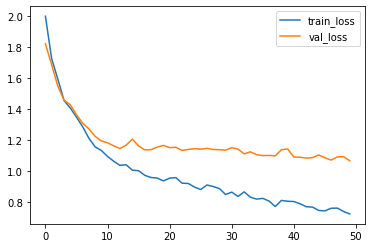

In [21]:
# plot validation curve
history[['train_loss', 'val_loss']].plot();

## Task 2 (2 points)
Make the model severely overfit

In [23]:
# TODO: create loaders
# TODO: create model
# TODO: train model


if history['val_loss'].iloc[-1] - history['train_loss'].iloc[-1] > 1.0:
    print('success!')

## Task 3 (2 points)
Beat the baseline  
You can change model architecture and hyperparams as you like  

In [24]:
# TOOD: select hyperparams and model architecture
# TODO: create loaders
# TODO: create model
# TODO: train model

In [ ]:
# load weights from best epoch

idx = np.argmin(history['val_loss'])
state_dict = torch.load(checkdir + '/epoch_%d_val_loss_%f' % (history.epoch.iloc[idx], history.val_loss.iloc[idx]))
model.load_state_dict(state_dict)

# test accuracy

model.eval()
test_acc = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)

        prediction = model(X)
        prediction = prediction.argmax(dim=-1)
        acc = (prediction ==  y.squeeze())
        acc = acc.data.cpu().detach().numpy()
        test_acc.extend( acc )

test_acc = np.mean(test_acc)
print('test accuracy', test_acc)
if test_acc > 0.75:
    print('success!')

## Task 4 (2 points)

If we have a fixed memory budget (number of weights is fixed), what is more efficient:  
wide network (`h_size >> 1`) or deep network (`n_blocks >> 1`) ?  
Make an experiment to prove your position.  
To avoid extreme cases, let put restrictions: 
* `n_blocks >=1` for wide network
* `h_size >= 64` for deep network

# Task 5 (2 points)
How are connected $L_2$ regularization and weight decay in the SGD optimizer?  
Does the same holds for Adam optimizer? Why?  